In [25]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import torchvision.utils as vutils
import os

In [11]:
batch_size =128
workers = 2
epochs = 20

latent_dim =100

gf_dim = 64
df_dim = 64

in_h = 64
in_w = 64
c_dim = 1

TINY = 1e-6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
transform = transforms.Compose(
    [
     transforms.Resize((in_h,in_w)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,)),
     ]
)

In [13]:
train_set = torchvision.datasets.MNIST(root='./mnist/',train=True,
                                      download=True,transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,
                                          shuffle =True, num_workers=workers)

test_set = torchvision.datasets.MNIST(root='./mnist/',train=False,
                                     download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle = False, num_workers=workers)

train_iter = iter(train_loader)
test_iter = iter(test_loader)

In [14]:
#### import torch.nn as nn
import torch.nn.functional as F

class generator(nn.Module):
  def __init__(self):
    super(generator,self).__init__()
    self.fc1 = nn.Linear(100, 8192)
    self.bn1 = nn.BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.cvt1 = nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    self.bn2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.cvt2 = nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    self.bn3 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.cvt3 = nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    self.bn4 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.cvt4 = nn.ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    
    
  def forward(self, x):
    x = F.relu(self.bn1(self.fc1(x))).view(-1, 64*8, 4, 4)
    x = F.relu(self.bn2(self.cvt1(x)))
    x = F.relu(self.bn3(self.cvt2(x)))
    x = F.relu(self.bn4(self.cvt3(x)))
    x = F.tanh(self.cvt4(x))
    return x

In [15]:
class discriminator(nn.Module):
  def __init__(self):
    super(discriminator,self).__init__()
    self.conv1 = nn.Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    self.conv2 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    self.bn1 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    self.bn2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.conv4 = nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    self.bn3 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.flatten = nn.Flatten(1)
    self.fc = nn.Linear(8192, 1, bias= True)

  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), negative_slope=0.1)
    x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.1)
    x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.1)
    x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.1)
    x = self.fc(self.flatten(x))
    return x

In [16]:
def V_criterion(x):
    x = torch.log(torch.tensor(2.))-torch.log(1.0+torch.exp(-x))
    return torch.mean(x)
    
    
def Q_criterion(x):
    x = torch.log(torch.tensor(2.))-torch.log(1.0+torch.exp(-x))
    x = torch.log(2.0-torch.exp(x))
    return torch.mean(x)

In [17]:
import torch.optim as optim

gen_model = generator().to(device)
dis_model = discriminator().to(device)

gen_optimizer = optim.Adam(gen_model.parameters(),lr=2e-4,betas=(0.5,0.9))
dis_optimizer = optim.Adam(dis_model.parameters(),lr=2e-4,betas=(0.5,0.9))

fixed_noise = torch.randn(batch_size, latent_dim,device=device)

In [18]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv')!=-1 or classname.find('Linear')!=-1:
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('BatchNorm')!=-1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)

print(gen_model.apply(weights_init))
print(dis_model.apply(weights_init))

generator(
  (fc1): Linear(in_features=100, out_features=8192, bias=True)
  (bn1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cvt1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cvt2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cvt3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cvt4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

In [22]:
img_list = []
gen_losses = []
dis_losses = []

iter_per_plot = 250
plot_per_eps=(int(len(train_loader)/iter_per_plot)+1)

transform_PIL=transforms.ToPILImage()

In [27]:
for ep in range(epochs):
  for i, (data, _) in enumerate(train_loader):
    bs=data.shape[0]
    data = data.to(device)

    #Train V
    dis_model.zero_grad()

    dis_output = dis_model(data)
    loss_real = -V_criterion(dis_output)
    loss_real.backward(retain_graph=True)

    z = torch.randn(bs,latent_dim).to(device)
    fake_data = gen_model(z)
    dis_fake = dis_model(fake_data.detach())
    loss_fake = -Q_criterion(dis_fake)
    loss_fake.backward()#maximize F

    loss_V = -(loss_real + loss_fake)
    dis_optimizer.step()

    #Train G 
    gen_model.zero_grad()
    dis_fake = dis_model(fake_data)

    loss_Q = -V_criterion(dis_fake)# maximize F (trick way)
    loss_Q.backward()
    gen_optimizer.step()


    if (i+1)%iter_per_plot == 0 or i ==0:
      print('Epoch [{}/{}], Step [{}/{}], V_loss: {:.4f}, Q_loss: {:.4f}' 
            .format(ep, epochs, i+1, len(train_loader), loss_V.item(), loss_Q.item()))
      gen_losses.append(loss_Q.item())
      dis_losses.append(loss_V.item())
      with torch.no_grad():
        fake = gen_model(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(torch.reshape(fake,(bs,c_dim,in_h,in_w))[:64], padding=2, normalize=True))
        transform_PIL(img_list[-1]).save(os.path.join('./logs',str(ep)+"_Last.png"))

Epoch [0/20], Step [1/469], V_loss: 1.3811, Q_loss: 8.5221
Epoch [0/20], Step [250/469], V_loss: 1.0378, Q_loss: 2.5678
Epoch [1/20], Step [1/469], V_loss: 0.9535, Q_loss: 1.5694
Epoch [1/20], Step [250/469], V_loss: 0.8892, Q_loss: 3.8685
Epoch [2/20], Step [1/469], V_loss: 1.0945, Q_loss: 6.1021
Epoch [2/20], Step [250/469], V_loss: 1.3591, Q_loss: 5.2842
Epoch [3/20], Step [1/469], V_loss: 1.1888, Q_loss: 4.2864
Epoch [3/20], Step [250/469], V_loss: 1.2172, Q_loss: 3.5709
Epoch [4/20], Step [1/469], V_loss: 1.1872, Q_loss: 6.2195
Epoch [4/20], Step [250/469], V_loss: 1.3189, Q_loss: 4.5561
Epoch [5/20], Step [1/469], V_loss: 1.1036, Q_loss: 11.4973
Epoch [5/20], Step [250/469], V_loss: 1.2024, Q_loss: 2.2182
Epoch [6/20], Step [1/469], V_loss: -0.2872, Q_loss: -0.6333
Epoch [6/20], Step [250/469], V_loss: 1.3637, Q_loss: 5.3982
Epoch [7/20], Step [1/469], V_loss: 1.2970, Q_loss: 3.9104
Epoch [7/20], Step [250/469], V_loss: 0.9513, Q_loss: 3.2745
Epoch [8/20], Step [1/469], V_loss: 1

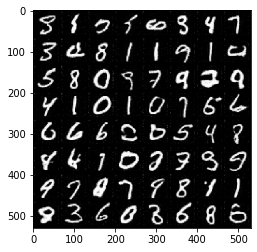

In [28]:
plt.imshow(plt.imread('./logs/19_Last.png'))

In [41]:
gen_losses =[7.069244384765625,
 8.202842712402344,
 8.522103309631348,
 2.567772388458252,
 1.5694289207458496,
 3.8684582710266113,
 6.102147579193115,
 5.284192085266113,
 4.286366939544678,
 3.57088565826416,
 6.219491958618164,
 4.556073188781738,
 11.497343063354492,
 2.21817946434021,
 -0.6332520246505737,
 5.398243427276611,
 3.9103550910949707,
 3.2744932174682617,
 6.607109069824219,
 3.930833101272583,
 5.719612121582031,
 5.976707458496094,
 8.60754108428955,
 5.893540382385254,
 13.257993698120117,
 4.998172760009766,
 2.7571849822998047,
 5.230459213256836,
 0.7952314615249634,
 6.19434928894043,
 6.769648551940918,
 6.8133015632629395,
 5.841485977172852,
 7.793423652648926,
 -0.6853713989257812,
 4.287713050842285,
 7.228137969970703,
 5.804088592529297,
 5.2878875732421875,
 4.43271541595459,
 8.292608261108398,
 6.627800941467285]

In [42]:
dis_losses = [1.366719365119934,
 1.3680665493011475,
 1.381148338317871,
 1.037771463394165,
 0.9535213708877563,
 0.8891764879226685,
 1.0944896936416626,
 1.3591467142105103,
 1.1887682676315308,
 1.2172081470489502,
 1.187168002128601,
 1.3189010620117188,
 1.1035995483398438,
 1.202404260635376,
 -0.2871553897857666,
 1.3636596202850342,
 1.2969609498977661,
 0.951317548751831,
 1.3767497539520264,
 1.2678227424621582,
 1.3738782405853271,
 1.3722792863845825,
 1.3564881086349487,
 1.3737106323242188,
 1.0233650207519531,
 1.213155746459961,
 0.6840722560882568,
 1.363387942314148,
 0.3836434483528137,
 1.3707597255706787,
 1.382406234741211,
 1.3819499015808105,
 1.3659939765930176,
 1.3845889568328857,
 0.5190085768699646,
 1.287275791168213,
 1.3841309547424316,
 1.374769926071167,
 1.373823642730713,
 1.3473981618881226,
 1.3847745656967163,
 1.3809609413146973]

In [43]:
gen_losses = gen_losses[2:]
dis_losses = dis_losses[2:]

No handles with labels found to put in legend.


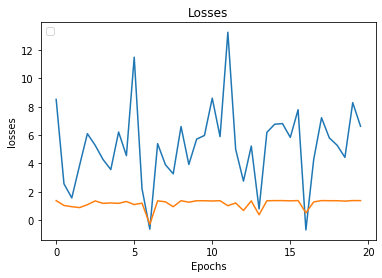

<Figure size 432x288 with 0 Axes>

In [45]:
plt.title("Losses")
epsilon = 1/plot_per_eps
X = np.array(range(plot_per_eps*epochs))/plot_per_eps

plt.plot(X,gen_losses)
plt.plot(X,dis_losses)
plt.legend(loc=2)
plt.xticks(np.arange(0,epochs+1,5)) 
plt.ylabel("losses")
plt.xlabel("Epochs")
plt.show()
plt.savefig("loss_figure.png")